In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist

/home/kk/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# train the VAE on MNIST digits
noise_factor = 0.5
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
num_train=len(x_train)
num_test=len(x_test)
x_train = x_train.reshape((num_train, 28,28,1))
x_test = x_test.reshape((num_test, 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.).astype('float32')
noise_test = np.clip(noise_test, 0., 1.).astype('float32')


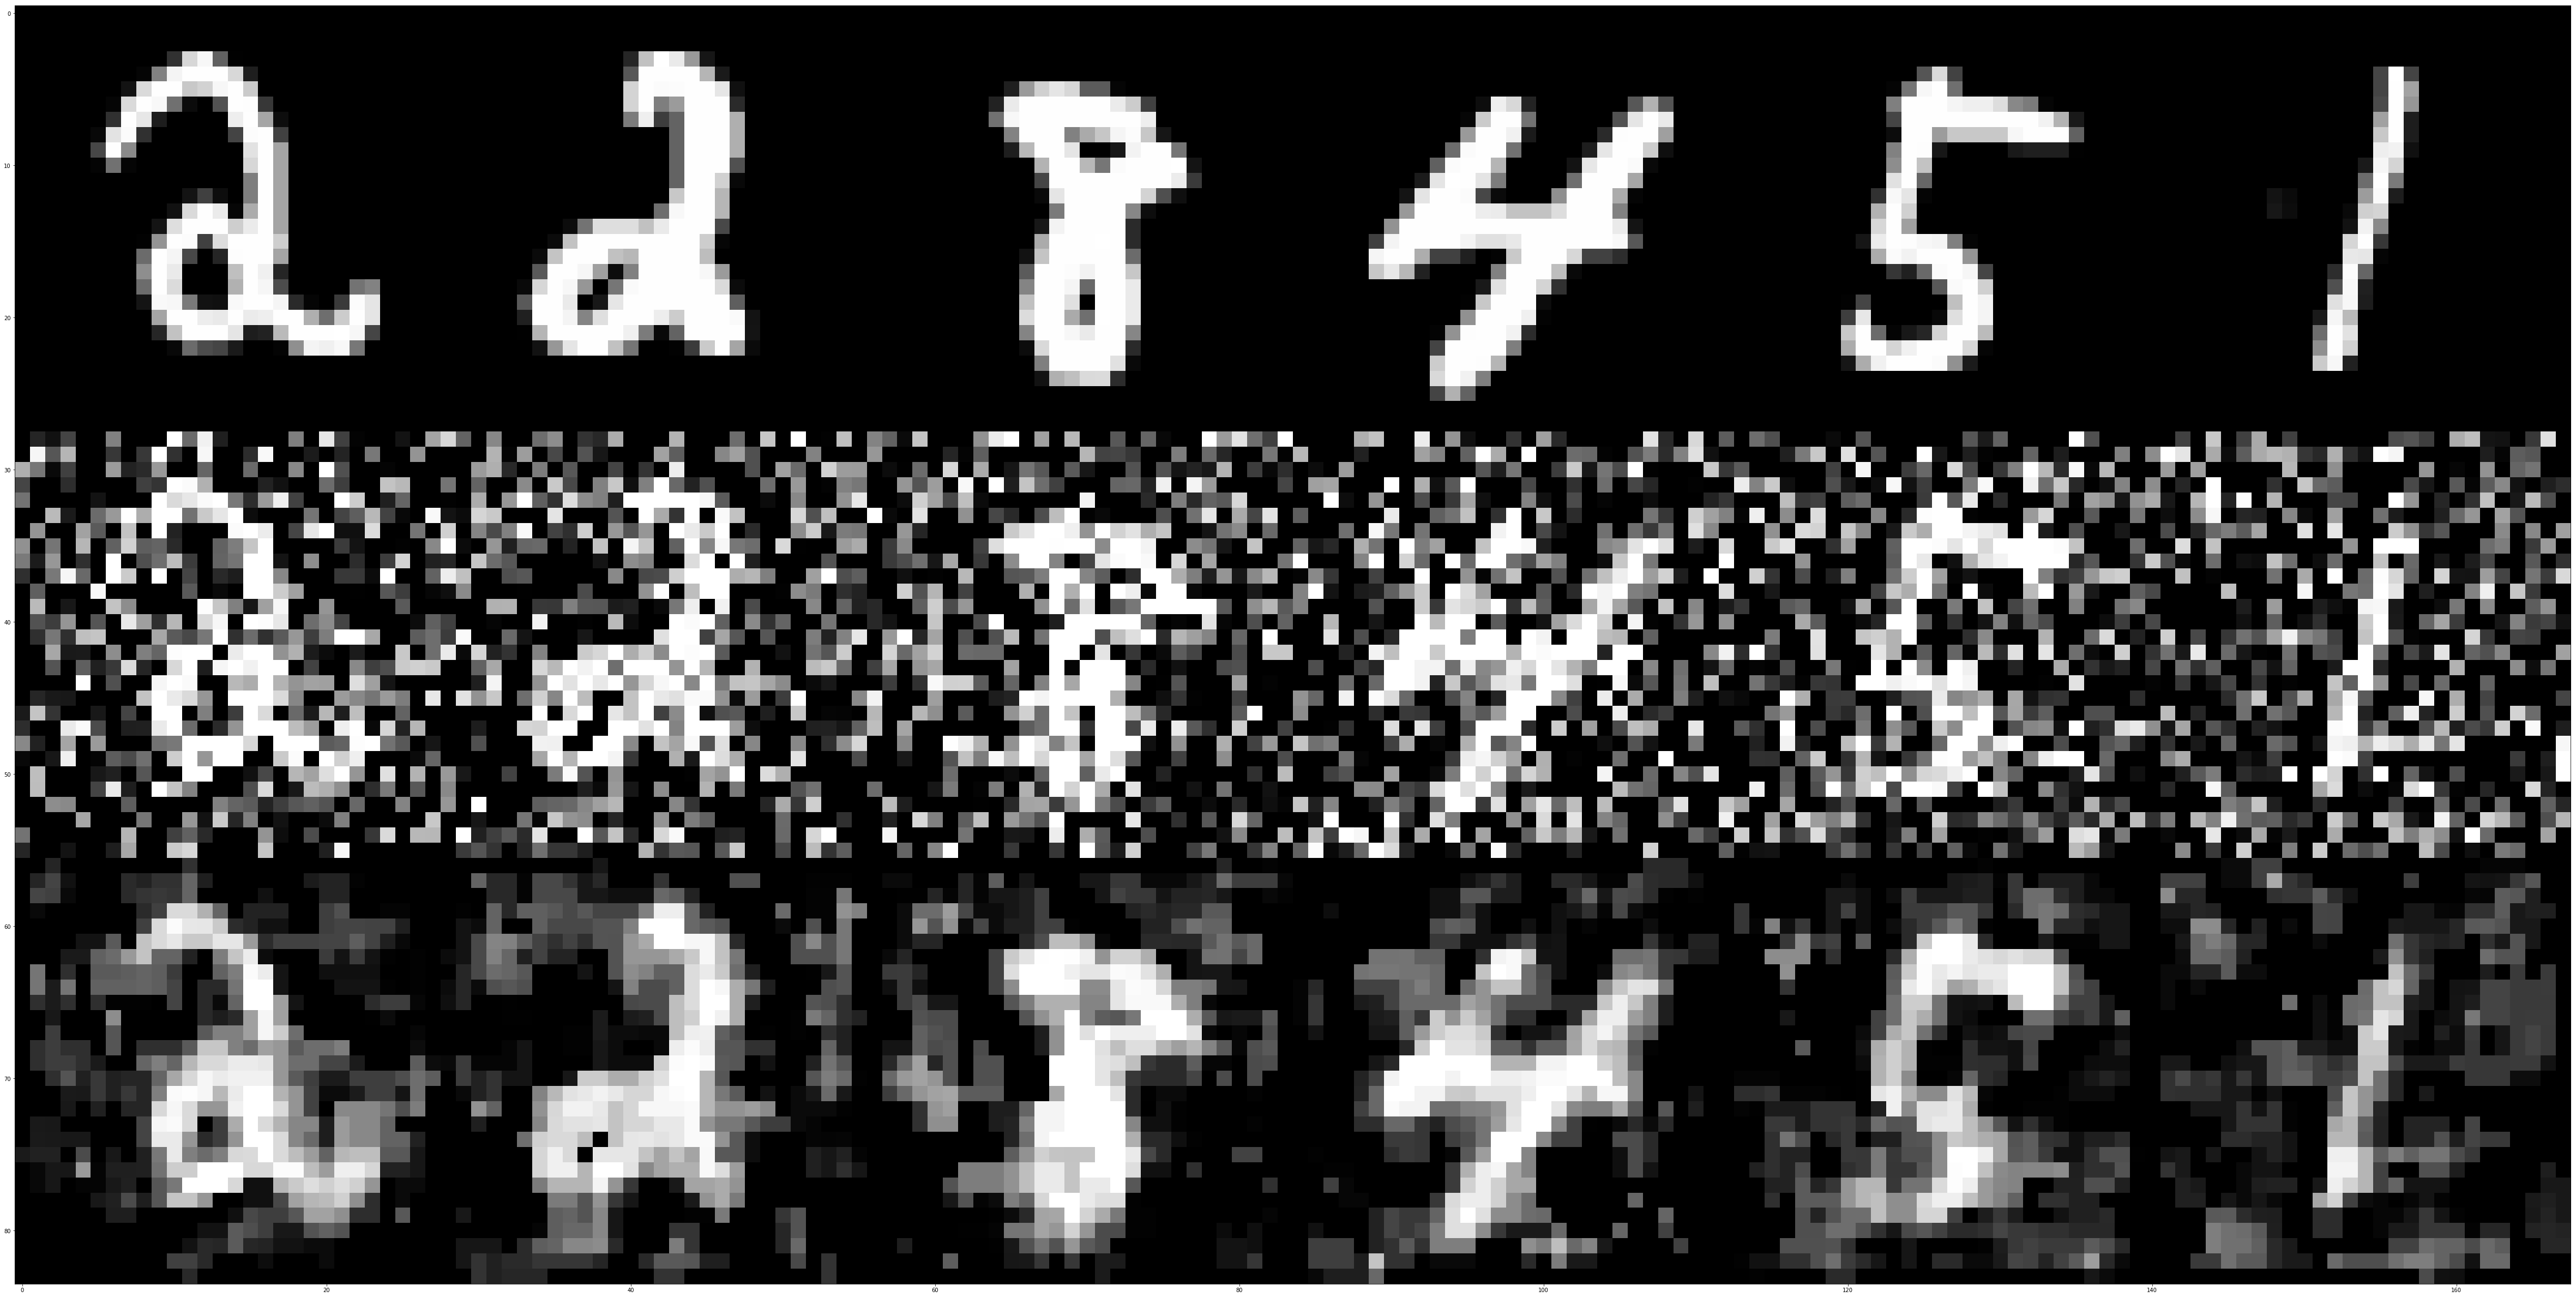

In [3]:
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [4]:
# Training Parameters
%matplotlib inline
learning_rate = 0.001
num_steps = 2500
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)

In [5]:
# Create the neural network
def AE(x_dict, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('autoencoder', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['noise']
        
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv3 = tf.layers.conv2d(pool1, 64, 3, activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(conv3, 2, 2)
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(pool2)
        fc1=tf.reshape(fc1,shape=[-1,1,1,1600])
        conv_0T = tf.layers.Conv2DTranspose(128,(1, 1),activation=tf.nn.relu)(fc1)#1*1
        conv_1T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_0T)#3*3
        conv_2T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_1T)#5*5
        conv_3T = tf.layers.Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_2T)#10*10
        conv_4T = tf.layers.Conv2DTranspose(48,(3, 3), activation=tf.nn.relu)(conv_3T)#12*12
        conv_5T = tf.layers.Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_4T)#24*24
        conv_6T = tf.layers.Conv2DTranspose(16,(3, 3), activation=tf.nn.relu)(conv_5T)#26*26
        out = tf.layers.Conv2DTranspose(1,(3, 3),activation=tf.nn.sigmoid)(conv_6T)#28*28
    #print(tf.layer.all_layers)
    return out

In [6]:
def AE_loss(x_reconstructed,x_true):
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    return tf.reduce_mean(encode_decode_loss)

In [7]:
# Define the model function (following TF Estimator Template)
def model_fn(features, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    decoder_train = AE(features, reuse=False, is_training=True)
    decoder_test = AE(features,reuse=True, is_training=False)
    
    flattendecoder=tf.reshape(decoder_train, shape=[-1, num_input, 1])
    flatteninput=tf.reshape(features['images'], shape=[-1, num_input, 1])
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=decoder_test) 
    
    # Define loss and optimizer
    #with tf.name_scope('Loss'):
    loss_op = AE_loss(flattendecoder,flatteninput)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    #acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    #tf.summary.scalar("loss", loss_op)
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss_op,
      train_op=train_op,
      #eval_metric_ops={'accuracy': acc_op}
    )
    
    return estim_specs

In [8]:
# Build the Estimator
#logs_path = '/tmp/tensorflow_logs/example/'
#summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_tf_random_seed': None, '_task_type': 'worker', '_is_chief': True, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_master': '', '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_service': None, '_task_id': 0, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f67e780b7b8>, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_model_dir': '/tmp/tmpd5yuyd08'}


In [9]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images':x_train,'noise':noise_train},
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpd5yuyd08/model.ckpt.
INFO:tensorflow:step = 1, loss = 543.4617
INFO:tensorflow:global_step/sec: 11.7766
INFO:tensorflow:step = 101, loss = 207.7575 (8.492 sec)
INFO:tensorflow:global_step/sec: 11.8512
INFO:tensorflow:step = 201, loss = 200.55663 (8.438 sec)
INFO:tensorflow:global_step/sec: 11.9254
INFO:tensorflow:step = 301, loss = 164.87457 (8.385 sec)
INFO:tensorflow:global_step/sec: 12.0362
INFO:tensorflow:step = 401, loss = 137.81021 (8.308 sec)
INFO:tensorflow:global_step/sec: 12.0747
INFO:tensorflow:step = 501, loss = 130.31085 (8.282 sec)
INFO:tensorflow:global_step/sec: 12.1181
INFO:tensorflow:step = 601, loss = 110.869896 (8.252 sec)
INFO:tensorflow:global_step/sec: 12.1206
INFO:tensorflow:step = 701, loss = 106.577286 (8.251 sec)
INFO:tensorflow:global_step/sec: 12.1457
INFO:tensorflow:step = 801, loss = 101.40561 (8.233 sec)
INFO:tensorflow:global_step/sec: 12.1613
INFO:tensorfl

In [10]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test,'noise': noise_test}, 
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-04-16-09:46:03
INFO:tensorflow:Restoring parameters from /tmp/tmpd5yuyd08/model.ckpt-2500
INFO:tensorflow:Finished evaluation at 2018-04-16-09:46:06
INFO:tensorflow:Saving dict for global step 2500: global_step = 2500, loss = 80.20555


{'global_step': 2500, 'loss': 80.20555}

INFO:tensorflow:Restoring parameters from /tmp/tmpd5yuyd08/model.ckpt-2500


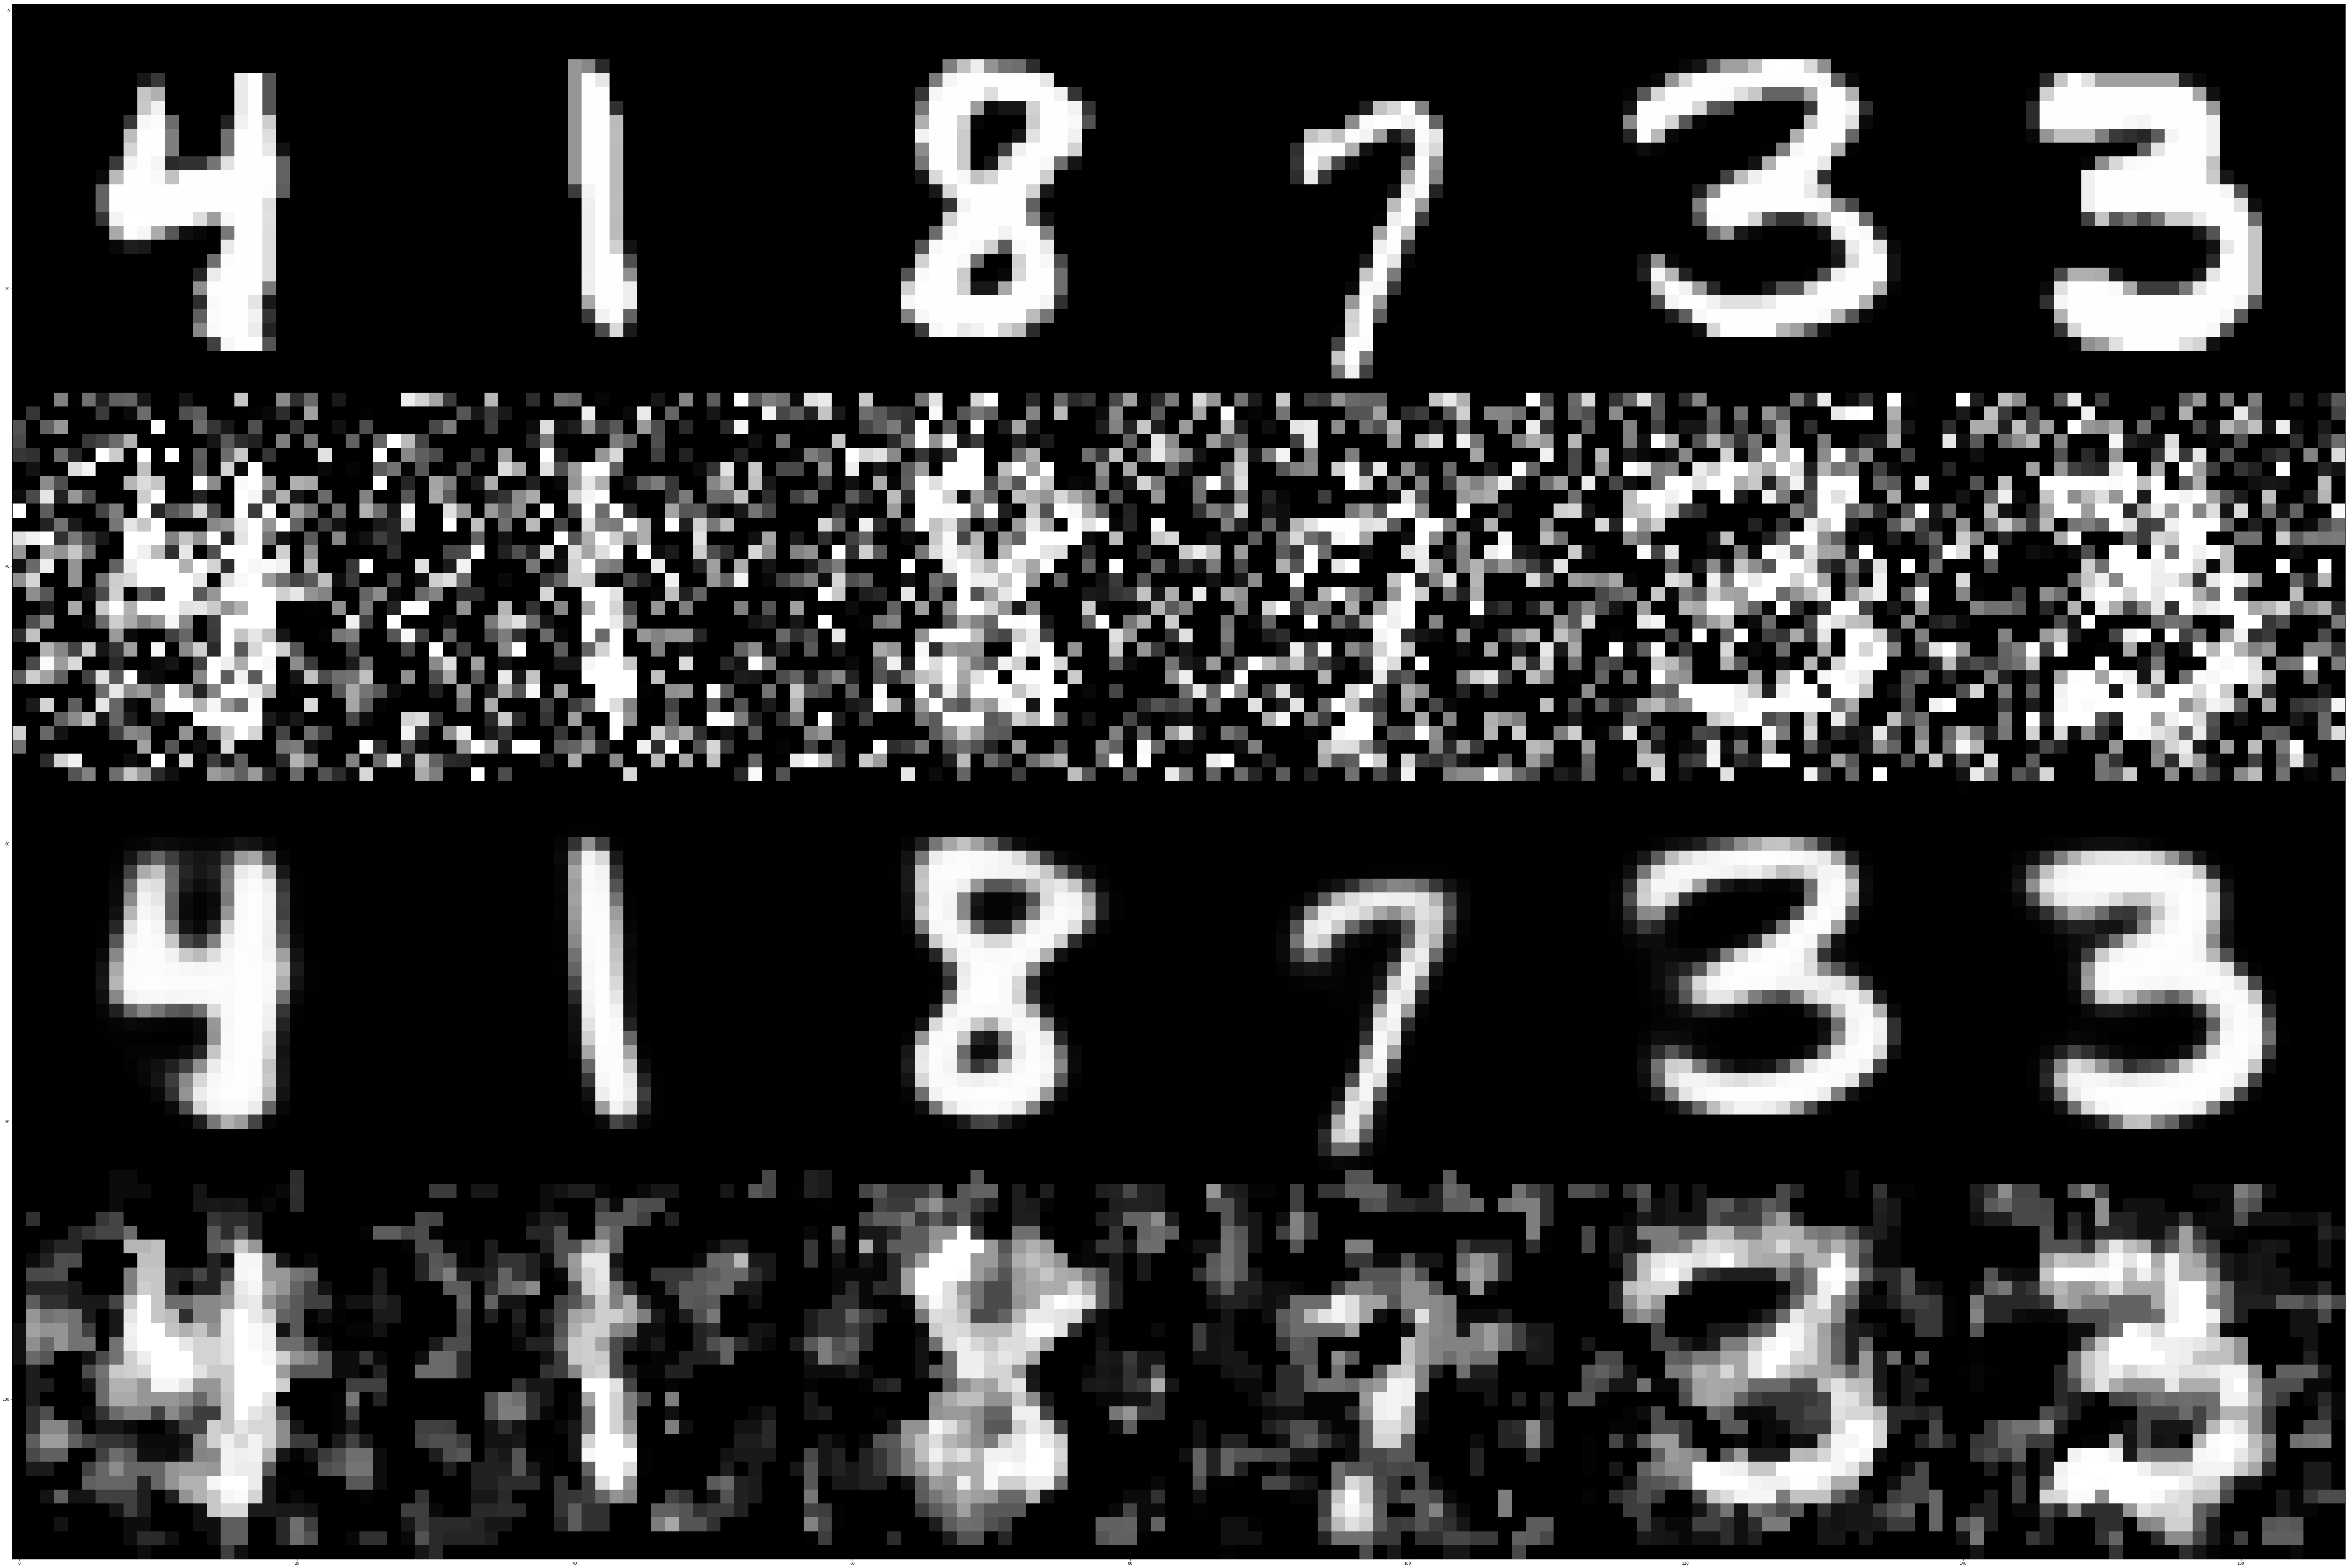

In [13]:
# Predict single images
# Get images from test set
showidx=np.random.randint(0,num_test,n_images)
test_images = x_test[showidx]
noise_images = noise_test[showidx]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images,'noise': noise_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
figure = np.zeros((28 * 4, 28 * n_images))
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(preds[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_tf_AE.png')
plt.show()